This notebook follows on from the `4_Neural Style Transfer - Layers Experiments.ipynb` notebook. It wraps up the initial efforts to optimize Neural Style Transfer, and presents the new baseline image.

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as display

# Getting the Images

In [2]:
# *****************************************************************************
# To get this code to work on your system, you may need to re-write this cell,
# depending on where you plan to run these files from. As you can see, I chose
# to put the files on my Google Drive and run them from there using Google
# Colab. You may choose another approach, such as running files locally.
# *****************************************************************************
from google.colab import drive
drive.mount('/content/drive')

base_image_path = "/content/drive/MyDrive/Colab Notebooks/CSCI_S-89/Final_Project/Images/Hinton.jpg"
style_image_path = "/content/drive/MyDrive/Colab Notebooks/CSCI_S-89/Final_Project/Images/GeorgeFloyd.jpg"

Mounted at /content/drive


In [3]:
# Make sure the images are a similar size. Widely differing sizes can make the
# style transfer more difficult.
original_width, original_height = keras.utils.load_img(base_image_path).size
img_height = 400
img_width = round(original_width * img_height / original_height)

In [4]:
# Opens, reizes, and converys an image into a numpy array.
def preprocess_image(image_path):
    img = keras.utils.load_img(
        image_path, target_size=(img_height, img_width))
    img = keras.utils.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    # Transform the the array (for use with VGG19 ImageNet).
    img = keras.applications.vgg19.preprocess_input(img)
    return img

# Converts a numpy array back into an image.
def deprocess_image(img):
    img = img.reshape((img_height, img_width, 3))
    # Zero-center the values by removing the mean pixel value from ImageNet.
    img[:, :, 0] += 103.939
    img[:, :, 1] += 116.779
    img[:, :, 2] += 123.68
    # Convert the images from BGR to RGB.
    img = img[:, :, ::-1]
    img = np.clip(img, 0, 255).astype("uint8")
    return img

In [5]:
base_image = preprocess_image(base_image_path)
style_image = preprocess_image(style_image_path)

# Setting up the Network

In [6]:
model = keras.applications.vgg19.VGG19(weights="imagenet", include_top=False)
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


# Choosing the Content and Style Layers

In [7]:
cl = "block5_conv2"
sl = ["block1_conv1", "block2_conv2", "block3_conv3", "block4_conv2", "block5_conv3"]

# Defining the Loss Functions

In [8]:
content_weight = 2.5e-8
style_weight = 1e-2
total_variation_weight = 1e-2

def content_loss(base_img, generated_img):
    # Compute the mean squared error between the two images.
    return tf.reduce_sum(tf.square(generated_img - base_img))

def gram_matrix(x):
    # Compute the Gram matrix.
    x = tf.transpose(x, (2, 0, 1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram

def style_loss(style_img, generated_img):
    # Compute the Gram matrices of the style and combination images.
    S = gram_matrix(style_img)
    C = gram_matrix(generated_img)
    channels = 3
    size = img_height * img_width
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))

def total_variation_loss(x):
    # Compute the total variation loss, which operates on the generated image.
    a = tf.square(x[:, : img_height - 1, : img_width - 1, :] - x[:, 1:, : img_width - 1, :])
    b = tf.square(x[:, : img_height - 1, : img_width - 1, :] - x[:, : img_height - 1, 1:, :])
    return tf.reduce_sum(tf.pow(a + b, 1.25))

def compute_loss(generated_image, base_image, style_image, content_layer_name, style_layer_names):
    input_tensor = tf.concat([base_image, style_image, generated_image], axis=0)
    features = feature_extractor(input_tensor)

    # Initialize the loss to zero.
    loss = tf.zeros(shape=())

    # Add the content loss.
    layer_features = features[content_layer_name]
    base_image_features = layer_features[0, :, :, :]
    generated_features = layer_features[2, :, :, :]
    loss = loss + content_weight * content_loss(base_image_features, generated_features)

    # Add the style loss.
    for layer_name in style_layer_names:
        layer_features = features[layer_name]
        style_features = layer_features[1, :, :, :]
        generated_features = layer_features[2, :, :, :]
        style_loss_value = style_loss(style_features, generated_features)
        loss += (style_weight / len(style_layer_names)) * style_loss_value

    # Add the total variation loss.
    loss += total_variation_weight * total_variation_loss(generated_image)
    return loss

# Performing the Gradient Descent

array([[[245, 176, 255],
        [241, 173, 255],
        [244, 181, 255],
        ...,
        [231, 188, 192],
        [228, 178, 203],
        [225, 170, 209]],

       [[241, 173, 255],
        [238, 173, 255],
        [243, 182, 255],
        ...,
        [235, 197, 188],
        [229, 184, 197],
        [229, 177, 206]],

       [[238, 177, 255],
        [236, 176, 255],
        [243, 185, 255],
        ...,
        [239, 210, 176],
        [229, 194, 182],
        [222, 185, 185]],

       ...,

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   6],
        [  0,   0,  14]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,  11],
        [  0,   0,  14],
        [  0,   0,  12]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,  19],
        [  0,   0,  22],
        [  0,   0,   0]]], dtype=uint8)
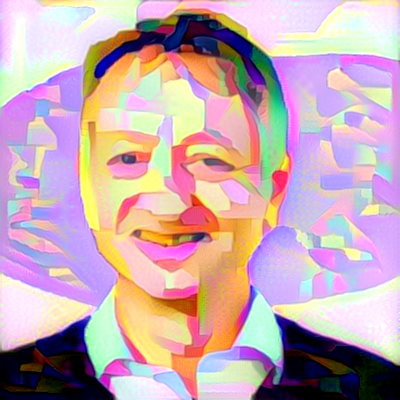

Train step: 4000


In [9]:
@tf.function
def compute_loss_and_grads(generated_image, base_image, style_image, content_layer_name, style_layer_names):
    with tf.GradientTape() as tape:
        loss = compute_loss(generated_image, base_image, style_image, content_layer_name, style_layer_names)
    grads = tape.gradient(loss, generated_image)
    return loss, grads

iterations = 4000

generated_image = tf.Variable(preprocess_image(base_image_path))

optimizer = keras.optimizers.RMSprop(
    learning_rate=tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=0.1, decay_steps=100, decay_rate=0.96
        ),
        rho=0.9,
        epsilon=1e-7
    )

for i in range(1, iterations + 1):
   loss, grads = compute_loss_and_grads(generated_image, base_image, style_image, cl, sl)
   optimizer.apply_gradients([(grads, generated_image)])
   print(".", end='', flush=True)
   if i % 100 == 0:
      print(f"Iteration {i}: loss={loss:.2f}")
      img = deprocess_image(generated_image.numpy())
      display.clear_output(wait=True)
      display.display(img)
      print("Train step: {}".format(i))